<a href="https://colab.research.google.com/github/amitpuri/Ask-picturize-it/blob/main/notebooks/demo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Usage

1. install client and connect to the API

In [ ]:
#%pip install ..
%pip install stability-sdk

In [ ]:
import getpass

# NB: host url is not prepended with \"https\" nor does it have a trailing slash.
STABILITY_HOST = 'grpc.stability.ai:443'

# To get your API key, visit https://beta.dreamstudio.ai/membership
STABILITY_KEY = getpass.getpass('Enter your API Key')

In [ ]:
import io
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
from stability_sdk.client import generation


stability_api = client.StabilityInference(
    host=STABILITY_HOST,
    key=STABILITY_KEY,
    verbose=True,
)

2. Submit a request to generate a single image from a text prompt

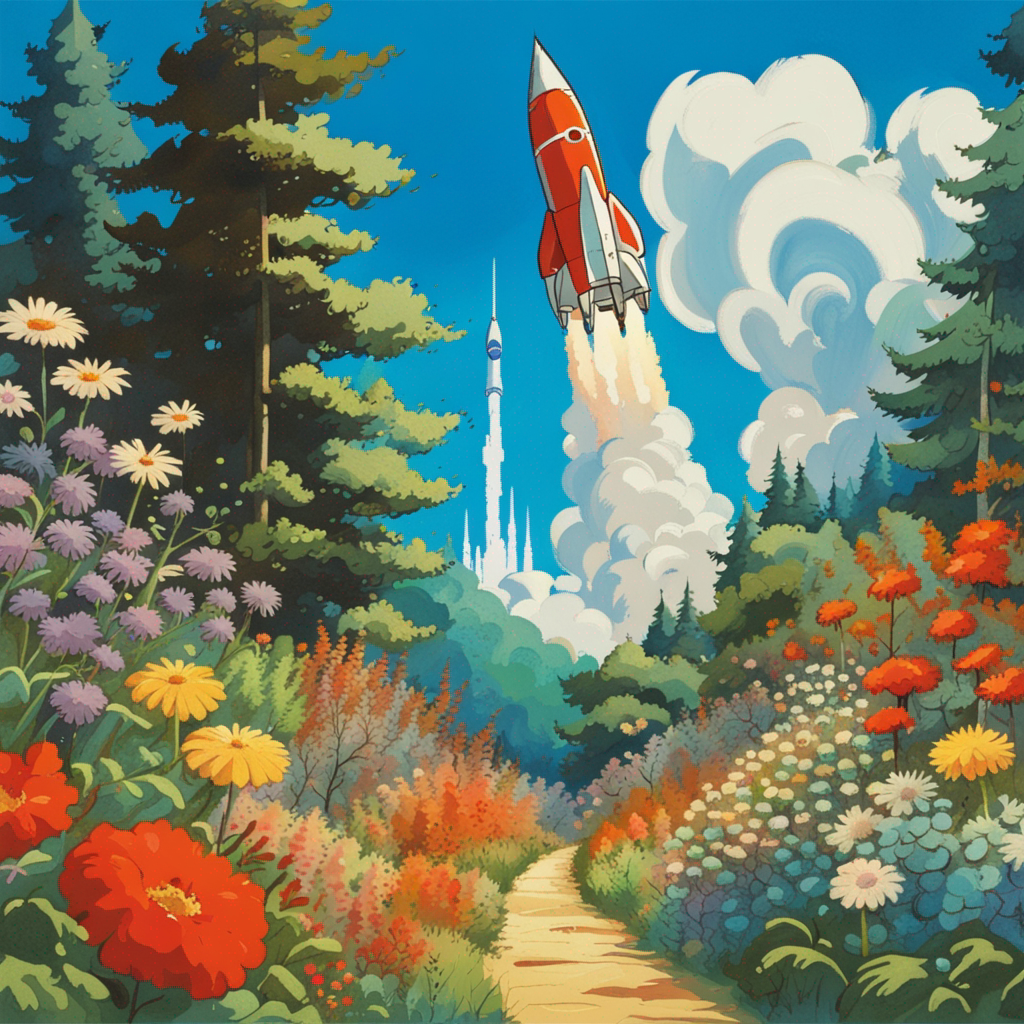

In [ ]:
# the object returned is a python generator
answers = stability_api.generate(
    prompt="rocket ship launching from forest with flower garden under a blue sky, masterful, ghibli",
    seed=121245125, # if provided, specifying a random seed makes results deterministic
    steps=50, # defaults to 30 if not specified
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

# Intermediate usage

3. An "init" image can be provided for text-driven image modification. To demonstrate, we can convert the image we just generated to a colored pencil sketch

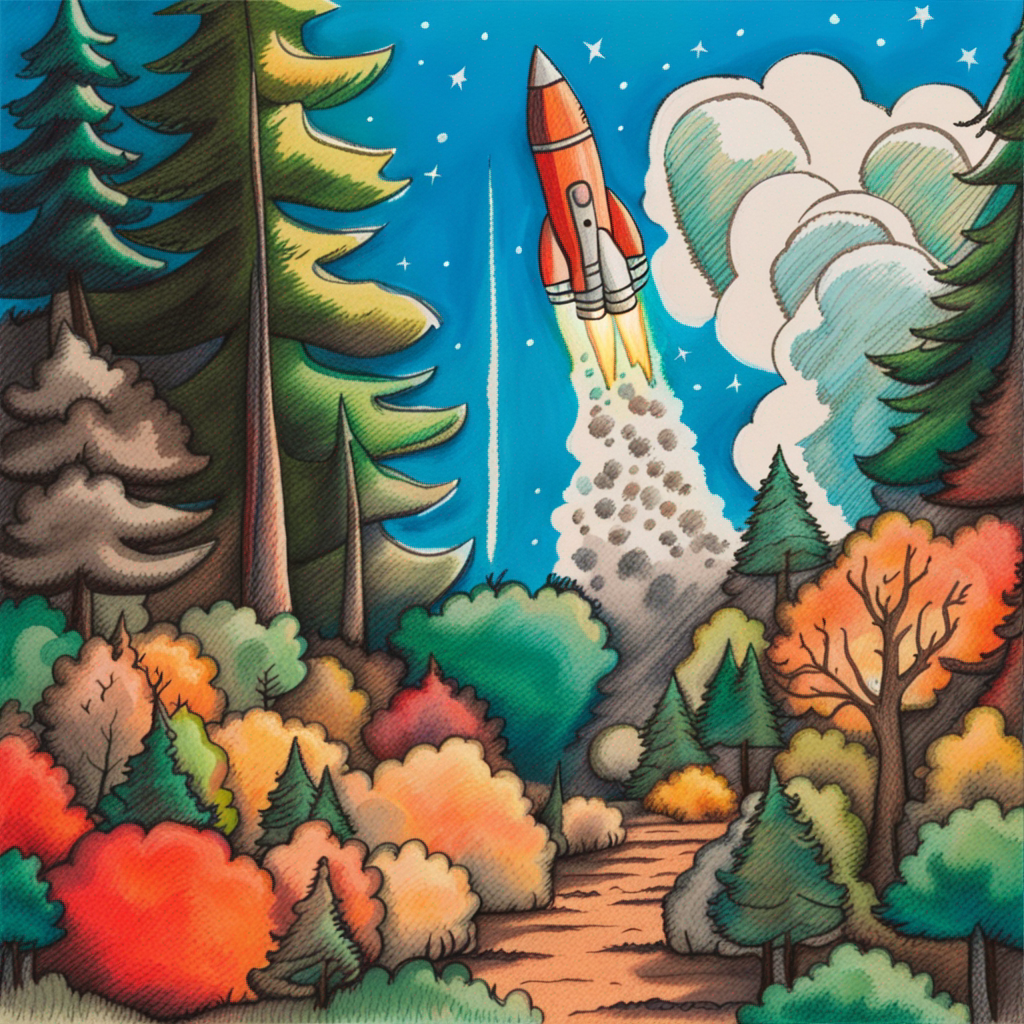

In [ ]:
answers = stability_api.generate(
    prompt="crayon drawing of rocket ship launching from forest",
    init_image=img,
    seed=123463446, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=0.6, # this controls the "strength" of the prompt relative to the init image
    steps=50,
    sampler=generation.SAMPLER_DDIM
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)

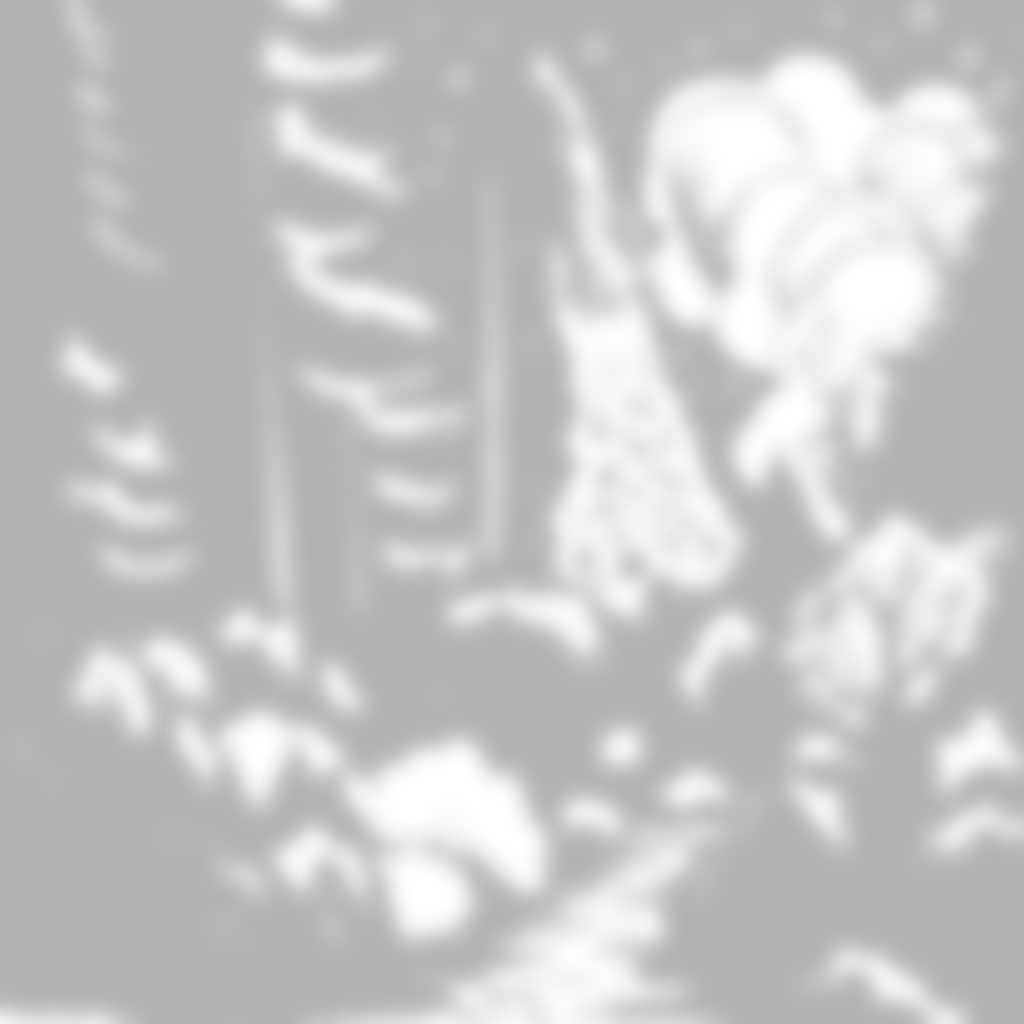

In [ ]:
# We can make a rough mask by thresholding the grayscaled image
import numpy as np

img2_grayscale = img2.convert('L')
img2_a = np.array(img2_grayscale)

mask = np.array(img2_grayscale)
mask[img2_a<150] = 0  # this is the area that will get painted, will show up black below
mask[img2_a>=150] = 1 # this is the protected area, will show up white below

strength = .3  # this controls the "strength" of the prompt relative to the init image

d = int(255 * (1-strength))
mask *= 255-d # convert from range [0,1] to [0,255]
mask += d
mask = Image.fromarray(mask)

# Blurring the mask edges generally improves synthesis results
from PIL import Image, ImageFilter
blur = ImageFilter.GaussianBlur(radius=10)
mask = mask.filter(blur)
mask

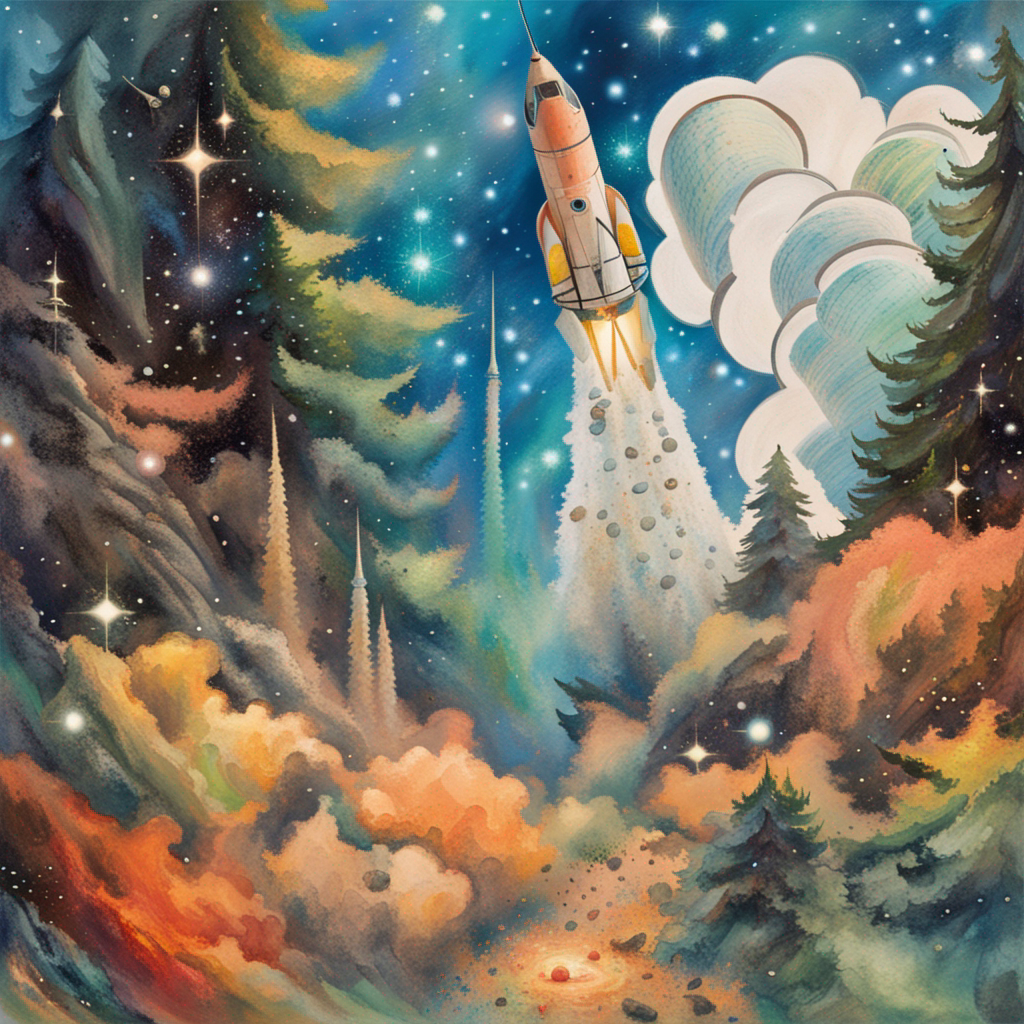

In [ ]:
# Now, let's send our drawing into space
answers = stability_api.generate(
    prompt="beautiful galaxies and stars in hubble telescope deep field",
    init_image=img2,
    mask_image=mask,
    seed=12345, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=1,
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

In [ ]:
# Upscaling
answers = stability_api.upscale(
    init_image=img3
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please submit a different image and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)